In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import ast

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine, euclidean
from tqdm import tqdm_notebook as tqdm

import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))
# from .. import gaussian_mixture_cotrain
from gaussian_mixture_cotrain import GaussianMixtureCotrain

from collections import Counter, defaultdict

from IPython.core.debugger import set_trace
from IPython.display import display

import matplotlib.pyplot as plt

from pprint import pprint

# Sample instances marked for certain identity categories

In [2]:
# Load labeled data
split = {}
s = 'train1000'
split[s] = pd.read_csv(f'/usr0/home/mamille2/tumblr/data/list_descriptions_{s}.csv', index_col=0)
print(split[s].columns)

Index(['tumblog_id', 'restr_segments_25', 'non-English', 'age', 'name',
       'personal description/commentary', 'location', 'interests',
       'adult content', 'sexual orientation', 'pronouns', 'gender', 'fandoms',
       'link to external content', 'occupation', 'astrological sign',
       'personality type', 'ethnicity/nationality', 'relationship status',
       'mental health', 'other/notes'],
      dtype='object')


In [8]:
pd.set_option('display.max_colwidth', -1)

In [13]:
# Sample from each column
# for c in list(split[s].columns)[2:-1]:
for c in ['non-English', 'age', 'name', 'location', 'interests', 'adult content',
         'sexual orientation', 'gender', 'pronouns', 'fandoms', 'link to external content',
         'occupation', 'personality type', 'astrological sign', 'ethnicity/nationality',
         'relationship status', 'mental health', 'personal description/commentary', 'other/notes']:
    print(c)
    display(split[s][split[s][c]==1].sample(n=5).loc[:, ['restr_segments_25', c]])
    print()

non-English


,restr_segments_25,non-English
2434608,"['wir sind wer wir sind', 'wir stehen zueinander', 'wir sind im untergrund', 'wir trinken und kiffen']",1.0
2344508,"['sto cercando me stessa', 'ho un obbiettivo: lui']",1.0
6097801,"['inglés', 'coreano💛']",1.0
260896,['日本語でおk'],1.0
6154294,['tŕic○ť e-t måčŕåm_ə'],1.0



age


,restr_segments_25,age
6137916,"['20', 'lg(b)t', 'east coast 🤔']",1.0
1293464,"['tallulah', '20', 'seattle']",1.0
4449537,"[""i'm an artist"", '15 years', 'чоткий паца']",1.0
3700323,"['25 m from geneva', 'i reblog stuff i like', 'mostly +18']",1.0
5813656,['composed by thoaria'],1.0



name


,restr_segments_25,name
3577861,"['magdalena jean brooks', '26\', ""cara\'s mommy"", \'"" - robert frost']",1.0
4852678,"['tea', 'pronounced tia', '17', 'ca']",1.0
976880,"['callum', '18', 'leo']",1.0
5395918,"['ann - 17 - she', 'her - primarily shyan', 'youtube']",1.0
45584,"['elizabeth', '23', 'she/her']",1.0



location


,restr_segments_25,location
4711226,"['zara', '19', 'essex']",1.0
3158204,"['abbey', 'twenty-one', 'toronto', '#1 style stan']",1.0
5541709,"['23', 'satx', '🤓💘']",1.0
3911020,"['ash', '21', 'uk ♥ 18+ side blog ♥']",1.0
1477244,"['21', 'massachusetts', 'taken💜']",1.0



interests


,restr_segments_25,interests
3001374,"['emmy', '17', 'probably writing']",1.0
4914497,"['merel', 'she/her', 'dutch', 'likes tacos and bad music']",1.0
1693564,"['welcome to my art blog', 'madness cave']",1.0
5623012,"['sasha', 'xv', 'faq']",1.0
3490756,"['ri', '20', 'girls', 'tattoos']",1.0



adult content


,restr_segments_25,adult content
5908844,"['selective', '17+ for nsfw', 'mun is 18']",1.0
4712484,"['consent is a must', 'enjoy']",1.0
1721994,['nsfw 18+'],1.0
4474728,"['abdl', 'but mostly abdl', ':) 18+ please!']",1.0
3617441,"['i am 40', 'i am smarter than most', 'i am twisted', 'i have a dark past', 'i make mistakes daily', 'adults only']",1.0



sexual orientation


,restr_segments_25,sexual orientation
3745083,"['weird', 'non-binary', 'otaku', 'aires', 'pansexual', 'writer', 'gamer', 'avenged sevenfold fan\', ""they, their, they\'re']",1.0
4616632,"['21', 'arizona', 'bisexual', 'emo hippie', 'lgbt activist', 'philanthropist', 'good vibes and high fives', 'tattoos & concerts', 'disney', 'horror films', ""i am satan's lover"", 'new years day']",1.0
3653226,"['maggie', '20s', 'bi', 'she/her']",1.0
5687068,"['19', 'nj —> pa', 'insta- amelia_elise123', '🌈🌈🌈']",1.0
3267373,"['but probably bisexual', 'chinese zodiac: horse', 'who knows', 'not me']",1.0



gender


,restr_segments_25,gender
1527688,"['crazy fan girl/otaku', 'reylo', 'touken', 'never judge me']",1.0
2289045,"['18', 'female', 'caramel skin']",1.0
4583991,"['21', 'baby girl', 'spiritual✨💕🌙']",1.0
5334423,"[""daddy's little bb girl""]",1.0
2305304,"['queer', 'artist', 'art connoisseur', '17']",1.0



pronouns


,restr_segments_25,pronouns
2278373,"['tyler', '13', 'she/they', 'pansexual', 'self taught artist']",1.0
1013712,"['emma', 'she/her', '16']",1.0
2667165,"['mars', '13', 'they•them•their']",1.0
45584,"['elizabeth', '23', 'she/her']",1.0
1152721,"['viola', 'she/her', 'denmark', '16', 'bi']",1.0



fandoms


,restr_segments_25,fandoms
2458753,['arianator🌙 girls power'],1.0
1727254,"['twentyonepilots', 'piercetheveil', 'panic!atthedisco']",1.0
5092937,"['always', 'taylor❤️']",1.0
1341420,"['mattelektra', 'kastle', 'the defenders', 'thorki', 'asgardians']",1.0
5345102,"['indie kaoru nagumo', 'semi-private', 'wip']",1.0



link to external content


,restr_segments_25,link to external content
2798884,['snapchat : chuchitaprods5'],1.0
4948117,"['i am ananya kashyap', 'my nickname is riya', 'i am on wattpad too']",1.0
4879568,"['lockscreens', 'edits', 'posts check out my ig!', 'flawlesskimchi17']",1.0
5395918,"['ann - 17 - she', 'her - primarily shyan', 'youtube']",1.0
3653510,"['♌ leonina', 'instagram : myllabitte', 'twitter : @myllab19', 'snapchat : myllabitte']",1.0



occupation


,restr_segments_25,occupation
1852102,"['sam', 'female', 'writer']",1.0
1526030,"[""hi! i'm a writer""]",1.0
2366790,"['anne', '16', 'hs junior', 'isfj']",1.0
5782832,"['melissa', '19', 'ucla', 'sf']",1.0
1876760,"['22', 'grad student']",1.0



personality type


,restr_segments_25,personality type
1307398,"['23', 'grumpy', 'medstudent', 'intj', 'loner', 'underdog', 'bisexual']",1.0
2830150,"['maya', 'intj', 'ravenclaw', 'bibliophile', 'music addict']",1.0
5616212,"['grace', 'she/they', '14', 'isfj', 'sherlock and anime']",1.0
4796799,"['17', 'entp', 'chaotic neutral']",1.0
4683170,"['aspiring film director', 'musician', 'gamer', 'intj', 'gryffindor', '17']",1.0



astrological sign


,restr_segments_25,astrological sign
4329683,"['crystal', '19', 'us', 'aries', 'tags']",1.0
1484269,"['20s', 'female', 'gemini disney', 'star wars', 'marvel']",1.0
4145422,"['17', '♋️', 'infp']",1.0
976880,"['callum', '18', 'leo']",1.0
1320569,"['🥀 they', 'them or he', 'him , infp , pisces, bi 🥀']",1.0



ethnicity/nationality


,restr_segments_25,ethnicity/nationality
5600856,"['20', 'chilena']",1.0
4874193,['asian princess and nympho'],1.0
1219397,"['instagram: pristinetrash', 'darian', '🇲🇽/🇺🇸', 'bi']",1.0
1035885,"['eunix kaija', 'asian']",1.0
3919978,"['baby', 'brasil', 'mg']",1.0



relationship status


,restr_segments_25,relationship status
5908287,"['eli (eee-lie)', 'he', 'him', 'mlm', 'i love my bf', 'my bf', 'posts about him']",1.0
4968912,"['single', 'lv. 15', 'ftm']",1.0
3746845,"['she / her', '18', 'taken', 'proceed at your own risk']",1.0
2115340,['happily married couple'],1.0
5891904,"['17', 'bi', 'taken']",1.0



mental health


,restr_segments_25,mental health
1865126,"['hey im anda', 'lover of the universe', 'i also want to fuckin die']",1.0
3784240,"['19', 'sad', 'lonely\\\\\\\\miserable\\\\\\\\']",1.0
5897239,"['fitness', 'foodie', 'self-love', 'body-positive']",1.0
5592086,['anxieties'],1.0
5304682,"['ruined', 'broken', 'empty']",1.0



personal description/commentary


,restr_segments_25,personal description/commentary
5071481,"['i\'m geek."", \'nope']",1.0
4972566,"['sarah', 'pennsylvania', 'nerd']",1.0
1411989,"[""you won't find better""]",1.0
5637184,"['a woodland fairy/witch', 'dm me!']",1.0
4833965,['suicidal'],1.0



other/notes


ValueError: a must be greater than 0

# Look for specific category values

In [8]:
# Load blog descriptions
descs = pd.read_pickle('/usr0/home/mamille2/tumblr/data/blog_descriptions_recent100.pkl')
len(descs)

5238440

In [9]:
descs.columns

Index(['tumblog_id', 'activity_time_epoch', 'tumblr_blog_name',
       'tumblr_blog_title', 'tumblr_blog_description', 'tumblr_blog_url',
       'tumblr_blog_theme', 'is_group_blog', 'is_primary', 'is_private',
       'created_time_epoch', 'updated_time_epoch', 'timezone', 'language',
       'blog_classifier', 'generated_date', 'parsed_blog_description'],
      dtype='object')

In [13]:
descs['parsed_blog_description'] = descs['parsed_blog_description'].fillna('')

In [15]:
search_term = r'bun\W'
selected = descs[descs['parsed_blog_description'].map(lambda x: True if re.search(search_term,x) else False)]
print(len(selected))
selected.loc[:,['parsed_blog_description']]

642


,parsed_blog_description
10936,my name is jasmine & I'm a nerdy grandma-libra...
15273,Kikobun's blog~
23752,Nebun în sensu' bun
39025,"god,faith, Shoaholic, Big earrings, jewlery, B..."
49962,keine beschreibun :D
56338,I'm the socially awkward kid you see sat in th...
70410,Hi! This is PrinceHonbun's main blog that I ap...
103054,big brother is ruining my life but Nicole's me...
108894,This blog is SFW(but not all the blogs I reblo...
110478,"Hiruko the baku, at your service. At least, if..."


# Word and character ngrams for identity category mention prediction

## Change CSV to pickle

In [8]:
# Load labeled data
split = {'dev200': None}
for s in split:
    split[s] = pd.read_csv(f'/usr0/home/mamille2/tumblr/data/list_descriptions_{s}.csv', index_col=0)
    print(split[s].columns)

Index(['tumblog_id', 'restr_segments_25', 'non-English', 'age', 'name',
       'personal description/ commentary', 'location', 'interests',
       'adult content', 'sexual orientation', 'pronouns', 'gender', 'fandoms',
       'link to external content', 'occupation', 'astrological sign',
       'personality type', 'ethnicity/ nationality', 'relationship status',
       'mental health', 'other/notes'],
      dtype='object')


In [9]:
def split_rm_punct(segments):
    """ Return segments split on punctuation, punctuation removed """
    
    new_segs = []
    
    for seg in segments:
        new_seg = ' '.join(re.split(r'\W', seg))
        new_seg = re.sub(r'\W', ' ', new_seg)
        new_seg = re.sub(r'\s+', ' ', new_seg).strip()
        new_segs.append(new_seg)
        
    return new_segs

In [10]:
# String representation to list
# split[s]['restr_segments_25'] = split[s]['restr_segments_25'].map(lambda x: x[2:-2].split("', '"))
split[s]['restr_segments_25'] = split[s]['restr_segments_25'].map(lambda x: ast.literal_eval(x))
split[s]['restr_segments_25']

3643035                                     [i am a unicorn]
4069522                              [porque no me interesa]
1270557                                   [also hella tired]
4539145    [and buy books, and read them, and buy more bo...
62017                                                   ['']
6131956              [sw:148lbs, cw:132lbs, ugw:99lbs (5'3)]
456892     [lost boys, first & foremost, ginger beard, i ...
2553397                                       [emmy, 21, uk]
5551910    [liv, 17, unapolgetic romantic, lover, she/her...
116277                     [23, chilean, capricorn, dreamer]
2870879                                             [enjoy!]
3669686                                           [teen boy]
5301452                      [elle woods, 18, and then some]
3635707    [i am a dragon, this is a human realm, enough ...
3729224            [23, london native, bare knuckle brawler]
571642                                [xviii, aries, dancer]
3254209        [bruna ma

In [12]:
split[s]['segments_25_nopunct'] = list(map(split_rm_punct, tqdm(split[s]['restr_segments_25'].tolist())))

HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

In [13]:
# NaNs -> 0
for c in ['gender', 'sexual orientation', 'pronouns']:
    split[s][c] = split[s][c].fillna(0)

In [14]:
split[s]['sexuality/gender'] = [max(tup) for tup in zip(split[s]['sexual orientation'], split[s]['gender'], split[s]['pronouns'])]
len(split[s][split[s]['sexuality/gender'] == 1])

21

In [15]:
split[s].to_pickle(f'/usr0/home/mamille2/tumblr/data/list_descriptions_{s}.pkl')

## Load data

In [2]:
# Load labeled data
split = {'train1000': None, 'dev200': None}
for s in split:
    split[s] = pd.read_pickle(f'/usr0/home/mamille2/tumblr/data/list_descriptions_{s}.pkl')
    print(split[s].columns)

Index(['tumblog_id', 'restr_segments_25', 'non-English', 'age', 'name',
       'personal description/commentary', 'location', 'interests',
       'adult content', 'sexual orientation', 'pronouns', 'gender', 'fandoms',
       'link to external content', 'occupation', 'astrological sign',
       'personality type', 'ethnicity/nationality', 'relationship status',
       'mental health', 'other/notes', 'segments_25_nopunct',
       'sexuality/gender'],
      dtype='object')
Index(['tumblog_id', 'restr_segments_25', 'non-English', 'age', 'name',
       'personal description/ commentary', 'location', 'interests',
       'adult content', 'sexual orientation', 'pronouns', 'gender', 'fandoms',
       'link to external content', 'occupation', 'astrological sign',
       'personality type', 'ethnicity/ nationality', 'relationship status',
       'mental health', 'other/notes', 'segments_25_nopunct',
       'sexuality/gender'],
      dtype='object')


## Unigrams and bag of character ngrams

In [27]:
vec_dict = {'unigrams': TfidfVectorizer(), 'char 1-4grams': TfidfVectorizer(analyzer='char', ngram_range=(1,4))}
clf_dict = {'NB': MultinomialNB(), 'SVM': svm.SVC()}
outcome_classes = ['sexual orientation', 'pronouns', 'gender', 'sexuality/gender']
bow = {s: {} for s in split}
labels = {s: {} for s in split}
outlines = []

# Get features
# Fit
for vec_name in vec_dict:
    data = [' '.join(segs) for segs in split['train1000']['segments_25_nopunct'].tolist()]
    vec_dict[vec_name].fit(data)

for s in split:
    for vec_name, vec in vec_dict.items():
        data = [' '.join(segs) for segs in split[s]['segments_25_nopunct'].tolist()]
        bow[s][vec_name] = vec.transform(data)
    
    # Get labels
    for l in outcome_classes:
        labels[s][l] = split[s][l].values

# Training
for vec_name in vec_dict:
    for l in outcome_classes:
        for clf_name, clf in clf_dict.items():
            clf.fit(bow['train1000'][vec_name], labels['train1000'][l])
            
            # Testing
            for s in split:
                preds = clf.predict(bow[s][vec_name])
                pos = preds==1 # positive guesses
                true_pos = labels[s][l]==1 # true positives
                matches = sum([all(tup) for tup in zip(pos, true_pos)])
                prec = f'{matches}/{sum(pos)} ({matches/sum(pos):.1%})'
                rec = f'{matches}/{sum(true_pos)} ({matches/sum(true_pos):.1%})'
            
                outlines.append([vec_name, clf_name, s, l, prec, rec])
        
pd.DataFrame(outlines, columns=['features', 'classifier', 'dataset', 'predicted class', 'precision', 'recall'])

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


,features,classifier,dataset,predicted class,precision,recall
0,unigrams,NB,train1000,sexual orientation,0/0 (nan%),0/57 (0.0%)
1,unigrams,NB,dev200,sexual orientation,0/0 (nan%),0/10 (0.0%)
2,unigrams,SVM,train1000,sexual orientation,0/0 (nan%),0/57 (0.0%)
3,unigrams,SVM,dev200,sexual orientation,0/0 (nan%),0/10 (0.0%)
4,unigrams,NB,train1000,pronouns,23/23 (100.0%),23/68 (33.8%)
5,unigrams,NB,dev200,pronouns,1/2 (50.0%),1/9 (11.1%)
6,unigrams,SVM,train1000,pronouns,0/0 (nan%),0/68 (0.0%)
7,unigrams,SVM,dev200,pronouns,0/0 (nan%),0/9 (0.0%)
8,unigrams,NB,train1000,gender,1/1 (100.0%),1/69 (1.4%)
9,unigrams,NB,dev200,gender,0/0 (nan%),0/6 (0.0%)


## 1-time

In [31]:
test = ['•draw for life•', '•a student•', '•18•']
split_rm_punct(test)

['draw for life', 'a student', '18']

# Pattern matching for mentions of identity categories

In [2]:
# Load labeled data
split = {'train1000': None, 'dev200': None}
for s in split:
    split[s] = pd.read_pickle(f'/usr0/home/mamille2/tumblr/data/list_descriptions_{s}.pkl')
    print(split[s].columns)

Index(['tumblog_id', 'restr_segments_25', 'non-English', 'age', 'name',
       'personal description/commentary', 'location', 'interests',
       'adult content', 'sexual orientation', 'pronouns', 'gender', 'fandoms',
       'link to external content', 'occupation', 'astrological sign',
       'personality type', 'ethnicity/nationality', 'relationship status',
       'mental health', 'other/notes', 'segments_25_nopunct',
       'sexuality/gender'],
      dtype='object')
Index(['tumblog_id', 'restr_segments_25', 'non-English', 'age', 'name',
       'personal description/ commentary', 'location', 'interests',
       'adult content', 'sexual orientation', 'pronouns', 'gender', 'fandoms',
       'link to external content', 'occupation', 'astrological sign',
       'personality type', 'ethnicity/ nationality', 'relationship status',
       'mental health', 'other/notes', 'segments_25_nopunct',
       'sexuality/gender'],
      dtype='object')


In [4]:
# Load nationalities
fpath = '/usr0/home/mamille2/tumblr/data/nationalities.txt'
with open(fpath) as f:
    nats = [nat.lower() for nat in f.read().splitlines()]
    
len(nats)

194

In [6]:
# Load ethnicities
fpath = '/usr0/home/mamille2/tumblr/data/ethnicities.txt'
with open(fpath) as f:
    eths = [e.split()[0].lower() for e in f.read().splitlines()]
    
len(eths)

1245

In [7]:
# Regex patterns
terms = {
        'age': [r'(?:[^-+\w]|^)([1-6]{1}[0-9]{1})[^-+]',
               r'twelve',
               r'thirteen',
               r'fourteen',
               r'fifteen',
               r'sixteen',
               r'seventeen',
               r'eighteen',
               r'nineteen',
               r'twenty',
               r'thirty',
               r'forty',
               r'fifty'
               r'sixty'],
        'location': [],
        'gender': [r'male\b', r'female', 
                    r'trans', r'ftm', r'mtf', r'cis',
                    r'girl\b', r'boy\b', r'\bman\b', r'guy\b', r'woman', r'gu+rl', r'gii+rl',
                    r'non-binary', r'nonbinary', r'nb', r'agender', r'neutrois',
                    r'\bmom\b', r'\bdad\b', r'wife', r'husband', r'\bbrother\b', r'\bson\b', r'\bsister\b',
                    r'bigender', r'lgbt'],
        'sexual orientation': 
                     [r'gay', r'straight', r'lesbian', r'\bhomo',
                       r'bisexual', r'\bbi\b', r'pansexual', r'\bpan\b',
                       r'lgbt', r'queer',
                       r'\bace\b', r'\basexual', r'aro-ace', r'aro/ace',
                     ],
         'pronouns': [
             r'(?:\W|\b)she(?:\W|\b)', r'(?:\W|\b)her(?:\W|\b)',
             r'(?:\W|\b)he(?:\W|\b)', r'(?:\W|\b)him(?:\W|\b)',
             r'(?:\W|\b)they(?:\W|\b)', r'(?:\W|\b)them(?:\W|\b)',
                ],
        'personality type': [
            '(?:i|e)(?:s|n)(?:t|f)(?:j|p)',
            'introvert',
            'extrovert'
            ],
        'ethnicity/nationality': eths + nats,
        'relationship status': [
            r'taken', r'married', r'single', r'engaged', r'husband', r'spouse', r'wife',
        ]
}
terms['sexuality/gender'] = terms['gender'] + terms['sexual orientation'] + terms['pronouns']

In [5]:
def has_category(cat, segments):
    ans = False
    
    if not isinstance(segments, list):
        return ans
    
    for c in terms[cat]:
        ans = any(re.search(c, s) for s in segments)
        if ans:
            break
            
    return ans

## Results

In [30]:
positives = {}
negatives = {}
truecat = {}
pos_matches = {}
outlines = []

for cat in terms:
    positives[cat] = {}
    negatives[cat] = {}
    truecat[cat] = {}
    pos_matches[cat] = {}
    
    for sp in split:
    
        preds = []
        preds = split[sp]['segments_25_nopunct'].map(lambda x: has_category(cat, x))

        # Get precision and recall
        positives[cat][sp] = preds[preds==True]
        negatives[cat][sp] = preds[preds==False]
        pos_matches[cat][sp] = set(positives[cat][sp].index).intersection(split[sp][split[sp][cat]==1].index)
        truecat[cat][sp] = split[sp][split[sp][cat]==1]

        prec = f'{len(pos_matches[cat][sp])}/{len(positives[cat][sp])} ({len(pos_matches[cat][sp])/len(positives[cat][sp]):.1%})'
        rec = f'{len(pos_matches[cat][sp])}/{len(truecat[cat][sp])} ({len(pos_matches[cat][sp])/len(truecat[cat][sp]):.1%})'

        outlines.append([sp, cat, prec, rec])
    
pd.DataFrame(outlines, columns=['dataset', 'predicted class', 'precision', 'recall'])

,dataset,predicted class,precision,recall
0,train1000,gender,55/64 (85.9%),55/69 (79.7%)
1,dev200,gender,5/10 (50.0%),5/6 (83.3%)
2,train1000,sexual orientation,53/57 (93.0%),53/57 (93.0%)
3,dev200,sexual orientation,10/10 (100.0%),10/10 (100.0%)
4,train1000,pronouns,68/74 (91.9%),68/68 (100.0%)
5,dev200,pronouns,9/14 (64.3%),9/9 (100.0%)
6,train1000,sexuality/gender,151/167 (90.4%),151/163 (92.6%)
7,dev200,sexuality/gender,21/29 (72.4%),21/21 (100.0%)


In [7]:
pd.set_option('display.max_colwidth', -1)

In [31]:
# Examine misclassified
cat = 'sexuality/gender'
sp = 'dev200'

print('False positives:')
false_positives = set(positives[cat][sp].index).intersection(split[sp][split[sp][cat]!=1].index)
display(split[sp].loc[false_positives, ['segments_25_nopunct', cat]])

print('False negatives:')
false_negatives = set(negatives[cat][sp].index).intersection(split[sp][split[sp][cat]==1].index)
display(split[sp].loc[false_negatives, ['segments_25_nopunct', cat]])

False positives:


,segments_25_nopunct,sexuality/gender
3358080,[pop cultured fangirl],0.0
6017699,"[the devil is real, he can be beautiful]",0.0
5612739,"[infp, 18yrs, he him]",0.0
5551910,"[liv, 17, unapolgetic romantic, lover, she her, movies, jazz, my tragic life]",0.0
4539145,"[and buy books, and read them, and buy more books]",0.0
232525,"[cars, woman, sport, woman, etc]",0.0
2352786,"[unusual girl, livy 22]",0.0
3669686,[teen boy],0.0


False negatives:


,segments_25_nopunct,sexuality/gender


In [33]:
for cat in ['sexual orientation', 'gender', 'pronouns', 'sexuality/gender']:
    print(cat)
    print(has_category(cat, split['dev200'].loc[4539145, 'segments_25_nopunct']))

sexual orientation
False
gender
False
pronouns
True
sexuality/gender
True


In [14]:
split[sp].loc[4539145]

tumblog_id                          349020059                                         
restr_segments_25                   [and buy books, and read them, and buy more books]
non-English                         NaN                                               
age                                 NaN                                               
name                                NaN                                               
personal description/ commentary    NaN                                               
location                            NaN                                               
interests                           1                                                 
adult content                       NaN                                               
sexual orientation                  0                                                 
pronouns                            0                                                 
gender                              0      

In [24]:
positives['sexuality/gender']['dev200']

4539145    True
5551910    True
3669686    True
3186675    True
5651639    True
682910     True
5717565    True
784560     True
692278     True
3684468    True
1787772    True
1674193    True
4988134    True
2352786    True
6129345    True
2628035    True
3358080    True
232525     True
1638645    True
2019633    True
6302691    True
477109     True
6066847    True
1632669    True
6017699    True
5393169    True
5612739    True
2549735    True
4740386    True
Name: restr_segments_25, dtype: bool

## Modifications

In [99]:
sp = 'train500'
# sp = 'dev100'
incorrect = split[sp][split[sp]['restr_segments_25'].map(lambda x: 'aromantic' in ' '.join(x))]
# incorrect = split[sp][split[sp]['restr_segments_25'].map(lambda x: 'poly' in ' '.join(x))]
incorrect
# mask = split['train500']['restr_segments_25'].map(lambda x: 'poly' in ' '.join(x) if isinstance(x, list))
# split['train500'][mask]

,tumblog_id,restr_segments_25,non-English,age,name,personal description/commentary,location,interests,adult content,sexual orientation,...,gender,fandoms,link to external content,occupation,astrological sign,ethnicity/nationality,personality type,other/notes,Unnamed: 20,some sexuality/gender
2234165.0,280919429.0,"[19, aromantic]",NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [115]:
# Corrections
sp = 'train500'
cat = 'pronouns'
val = 1
# sp = 'dev100'

# for i in incorrect.index:
for i in [3047905]:
    split[sp].loc[i, cat] = val
    
len(split[sp])

500

In [64]:
split['train500']['gender'] = split['train500']['gender'].fillna(0)

In [21]:
# Convert from string to list
split['dev100']['restr_segments_25'] = split['dev100']['restr_segments_25'].map(lambda x: x[2:-2].split("', '") if isinstance(x, str) else x)
split['dev100']['restr_segments_25']

5092937                                   [always, taylor❤️]
4963722                          [et c'est du lolz en barre]
5076844                              [15, she-her, bisexual]
5328135                 [finn, 20, trans dude separate nsfw]
5211281                   [random person, between 18 and 28]
4890568                                           [welcome🌹]
5167827    [16, cancer, pakistani- belgian muslim, geek/ ...
5310836                         [libra and dead, ya la cage]
5162449                                [except when i'm not]
4952852                     [antonio, 17, italy, moon child]
5212408                                  [raven, 17, pisces]
5518612                                       [hi, im  mina]
4911590    [•amanda•, cuddlebug, •green eyes•, freckles, ...
4964783                                         [smartapple]
5236083                                 [shrektum my rectum]
5019972                          [sizde gelin içinizi dökün]
5148628    [🕸 jay, 18, v

In [80]:
# Remove mistake settings
split['train500'] = split['train500'][split['train500']['restr_segments_25'].map(lambda x: not isinstance(x, float))]
len(split['train500'])

500

In [89]:
# Remove mistake settings
split['dev100'] = split['dev100'][split['dev100']['restr_segments_25'].map(lambda x: not isinstance(x, float))]
len(split['dev100'])

100

In [4]:
split = {}
s = 'train1000'
split[s] = pd.read_csv(f'/usr0/home/mamille2/tumblr/data/list_descriptions_{s}.csv', index_col=0)
len(split[s])

1000

In [7]:
# Convert from string to list
split[s]['restr_segments_25'] = split[s]['restr_segments_25'].map(lambda x: x[2:-2].split("', '") if isinstance(x, str) else x)
split[s]['restr_segments_25']

5927777                      [supreme overlord(tm), he, him]
5705254    [23, dirty, bruises, rapeplay, bdsm, blood, hu...
6036998              [21, aquarius, montreal qc, sudbury on]
5627590                                [requests: open\xa0✓]
6222904                              [engaged, bored, tired]
6205695                                       [5ft 1, 112lb]
5878331                                           [location]
5782832                              [melissa, 19, ucla, sf]
5909409             [i'm eleven turning twelve", 'thank you]
6128417    [ava, fob, mcr, p!atd, tøp, green day, anythin...
6273890                            [pro-recovery, stay safe]
5771853                     [not many understand this, -slh]
6104988                         [err, reblogs only (for now]
5566861                                  [google+ mein blog]
6143120                                       [i kid, i kid]
5880624    [forse c'è ancora speranza", 'qualcosa per cui...
5647998       [\\\\ i ca

In [8]:
split[s].to_pickle(f'/usr0/home/mamille2/tumblr/data/list_descriptions_{s}.pkl')

In [116]:
split['dev100'].to_pickle('/usr0/home/mamille2/tumblr/data/list_descriptions_dev100.pkl')
split['dev100'].to_csv('/usr0/home/mamille2/tumblr/data/list_descriptions_dev100.csv')
split['train500'].to_pickle('/usr0/home/mamille2/tumblr/data/list_descriptions_train500.pkl')
split['train500'].to_csv('/usr0/home/mamille2/tumblr/data/list_descriptions_train500.csv')

## 1-time

In [26]:
preds = []
preds = split['dev200']['restr_segments_25'].map(lambda x: has_category('sexuality/gender', x))
preds[preds==True]

4539145    True
5551910    True
3669686    True
3186675    True
5651639    True
682910     True
5717565    True
784560     True
692278     True
3684468    True
1787772    True
1674193    True
4988134    True
2352786    True
6129345    True
2628035    True
3358080    True
232525     True
1638645    True
2019633    True
6302691    True
477109     True
6066847    True
1632669    True
6017699    True
5393169    True
5612739    True
2549735    True
4740386    True
Name: restr_segments_25, dtype: bool

In [28]:
has_category('sexuality/gender', split['dev200'].loc[4539145,'restr_segments_25'])

True

In [19]:
has_category('gender', ['male', '28'])

True

In [52]:
has_category('gender', ['girl', '28'])

True

In [74]:
has_category('sexual orientation', ['pan as fuck', '28'])

True

In [110]:
has_category('pronouns', ['she/her', 'them', 'he'])

True

In [111]:
has_category('pronouns', ['banshee'])

False

In [112]:
has_category('pronouns', ['he they'])

True

# Qualitatively examine description segments

In [48]:
# Load descriptions
list_desc_data = pd.read_pickle('/usr0/home/mamille2/tumblr/data/list_descriptions.pkl')
print(len(list_desc_data))
print(list_desc_data.columns)

844936
Index(['tumblog_id', 'activity_time_epoch', 'tumblr_blog_name',
       'tumblr_blog_title', 'tumblr_blog_description', 'tumblr_blog_url',
       'tumblr_blog_theme', 'is_group_blog', 'is_primary', 'is_private',
       'created_time_epoch', 'updated_time_epoch', 'timezone', 'language',
       'blog_classifier', 'generated_date', 'parsed_blog_description',
       'tokenized_blog_description', 'segments'],
      dtype='object')


In [50]:
pd.set_option('display.max_colwidth', 999)

In [53]:
samp = list_desc_data.sample(30)
samp

,tumblog_id,activity_time_epoch,tumblr_blog_name,tumblr_blog_title,tumblr_blog_description,tumblr_blog_url,tumblr_blog_theme,is_group_blog,is_primary,is_private,created_time_epoch,updated_time_epoch,timezone,language,blog_classifier,generated_date,parsed_blog_description,tokenized_blog_description,segments
153799,264610491.0,1.490042e+12,milton-sarges,Stay Positive,"😉""A vida foi feita pra quem gosta de viver...""😏✌",https://milton-sarges.tumblr.com/,NaN,False,True,False,1448192608000,1490041619000,US/Eastern,en_US,safe,20171119,"😉""A vida foi feita pra quem gosta de viver...""😏✌","[😉""a, vida, foi, feita, pra, quem, gosta, de, viver, ..., ""😏✌]","[😉""A vida foi feita pra quem gosta de viver, ""😏✌]"
1009489,305166363.0,1.511213e+12,buckyskindahottho,Profesh Leaf Blower,<p>Hello. I'm Marrissa.</p><p>Multifandom af. </p><p>I reblog a lot of hockey shit now Bc I don't know who I am anymore</p>,http://buckyskindahottho.tumblr.com/,NaN,False,True,False,1468778465000,1510700344000,US/Eastern,en_US,safe,20171120,Hello. I'm Marrissa. Multifandom af. I reblog a lot of hockey shit now Bc I don't know who I am anymore,"[hello, ., i, 'm, marrissa, ., multifandom, af, ., , i, reblog, a, lot, of, hockey, shit, now, bc, i, do, n't, know, who, i, am, anymore]","[Hello, I'm Marrissa, Multifandom af, I reblog a lot of hockey shit now Bc I don't know who I am anymore]"
1272238,330361163.0,1.483852e+12,badlilbunny,18+,<p>What up. I'm bunny. 22. NSFW.</p><p>I will block all minors.</p><p>Don't want to see your dick.</p>,https://badlilbunny.tumblr.com/,NaN,False,False,False,1483851537000,1483851892000,US/Eastern,en_US,safe,20171115,What up. I'm bunny. 22. NSFW. I will block all minors. Don't want to see your dick.,"[what, up, ., i, 'm, bunny, ., 22, ., nsfw, ., i, will, block, all, minors, ., do, n't, want, to, see, your, dick, .]","[What up, I'm bunny, 22, NSFW, I will block all minors, Don't want to see your dick]"
1094766,236121642.0,1.436473e+12,fargo3d,Little Printer on the Prairie,So you can build stuff. fargo3dprinting.com,http://fargo3d.tumblr.com/,NaN,False,True,False,1431616860000,1432325950000,US/Eastern,en_US,NaN,20171111,So you can build stuff. fargo3dprinting.com,"[so, you, can, build, stuff, ., , fargo3dprinting.com]","[So you can build stuff, fargo3dprinting, com]"
2243461,9649784.0,1.476566e+12,laurendean-blog,amazing wonder.,i'm lauren. i've learned to live my life the way i want. i made this to rant about obstacles life has thrown at me. <3,http://laurendean-blog.tumblr.com/,NaN,False,True,False,1289487107000,1476566239000,US/Eastern,en_US,safe,20171113,i'm lauren. i've learned to live my life the way i want. i made this to rant about obstacles life has thrown at me. < 3,"[i, 'm, lauren, ., i, 've, learned, to, live, my, life, the, way, i, want, ., i, made, this, to, rant, about, obstacles, life, has, thrown, at, me, ., , <, 3]","[i'm lauren, i've learned to live my life the way i want, i made this to rant about obstacles life has thrown at me, < 3]"
2434214,42142517.0,1.445377e+12,xdreamyjen-blog,[ Jen-chan ],. Jen | Girl | 16-year-old | Finland | AMV editor .,http://xdreamyjen-blog.tumblr.com/,NaN,False,True,False,1327508071000,1445377075000,Europe/Kiev,en_US,NaN,20171120,. Jen | Girl | 16-year-old | Finland | AMV editor .,"[., jen, |, girl, |, 16-year, -, old, |, finland, |, amv, editor, .]","[. Jen, Girl, 16-year-old, Finland, AMV editor .]"
4318034,233387659.0,1.438465e+12,ohmypasta,Under Water,<p>Birds are weird...</p>,http://ohmypasta.tumblr.com/,NaN,False,True,False,1429988328000,1438464948000,Europe/Amsterdam,en_US,NaN,20171111,Birds are weird...,"[birds, are, weird, ...]",[Birds are weird]
2170249,240480240.0,1.451782e+12,miqote-nip,K'hirto Tia,Seeker of the Sun / Monk / Odin Server. Mostly posting Art and screenies sporadically. RPing is cool too though.,http://miqote-nip.tumblr.com/,NaN,False,False,False,1434117320000,1451782235000,US/Eastern,en_US,NaN,20171118,Seeker of the Sun / Monk / Odin Server. Mostly posting Ar

# Examine Brown clustering of description segments

In [32]:
with open('/usr0/home/mamille2/brown-cluster/desc_segments_20-c50-p1.out/paths') as f:
# with open('/usr0/home/mamille2/brown-cluster/desc_segments_20_freq-c50-p1.out/paths') as f:
    lines = f.read().splitlines()
    
len(lines)

282607

In [37]:
outlines = []

for l in lines:
    l_split = l.split('\t')
    if len(l_split) == 3:
        outlines.append(l_split)
#         clu['all'][l_split[0]].append(l_split[1])
    
# print(len(clu['all']))
# clu['all'].keys()

clu = pd.DataFrame(outlines, columns=['cluster', 'word', 'freq'])
clu

,cluster,word,freq
0,000,❌💀indie,1
1,000,lover🎈,1
2,000,sweet-tums,1
3,000,com/ejpixx,1
4,000,woodkid,1
5,000,/sweden,1
6,000,hikers,1
7,000,5-2,1
8,000,#greatoverextreme,1
9,000,diya,1


In [38]:
clu['freq'] = clu['freq'].astype(int)

In [39]:
clu.sort_values(['cluster', 'freq'], inplace=True, ascending=False)
clu

,cluster,word,freq
282590,11111,her,2838
282591,11111,relax,2187
282589,11111,them,2183
282588,11111,him,1897
282587,11111,moon,939
282586,11111,sun,878
282585,11111,pronouns,870
282584,11111,wolf,544
282583,11111,rising,390
282582,11111,dan,368


In [41]:
pd.set_option('display.max_rows', 999)

In [42]:
clu

,cluster,word,freq
282590,11111,her,2838
282591,11111,relax,2187
282589,11111,them,2183
282588,11111,him,1897
282587,11111,moon,939
282586,11111,sun,878
282585,11111,pronouns,870
282584,11111,wolf,544
282583,11111,rising,390
282582,11111,dan,368


In [45]:
for val in clu['cluster'].unique():
    rows = clu[clu['cluster']==val]
    print(rows.head(20))
    print()

       cluster      word  freq
282590   11111       her  2838
282591   11111     relax  2187
282589   11111      them  2183
282588   11111       him  1897
282587   11111      moon   939
282586   11111       sun   878
282585   11111  pronouns   870
282584   11111      wolf   544
282583   11111    rising   390
282582   11111       dan   368
282581   11111   angeles   322
282580   11111     diego   207
282579   11111    lovato   188
282578   11111    states   182
282577   11111      rico   168
282576   11111     pride   160
282575   11111      her)   146
282574   11111  martinez   145
282573   11111      edge   143
282572   11111   pierced   138

       cluster          word  freq
264768   11110          girl  6639
264770   11110       student  6013
264771   11110       she/her  5670
264769   11110        female  4935
264767   11110        artist  4706
264766   11110           gay  4407
264765   11110        single  4176
264764   11110        writer  4136
264763   11110          male  402

         cluster          word  freq
126170  01111100           18+  7813
126171  01111100           +18   537
126169  01111100           21+   411
126168  01111100        adults   291
126167  01111100     multiship   286
126166  01111100          semi   197
126165  01111100    multi-ship   171
126164  01111100  occasionally   158
126163  01111100            dd   149
126161  01111100           cgl   145
126162  01111100        highly   145
126160  01111100    fandomless   139
126159  01111100    definitely   113
126158  01111100           ooc    96
126157  01111100      possible    91
126156  01111100       18+only    89
126154  01111100         (18+)    83
126155  01111100           20+    83
126153  01111100       mutuals    80
126152  01111100    multi-muse    75

       cluster     word  freq
122115  011110       no  5976
122116  011110       so  4819
122114  011110     here  4087
122113  011110      one  4072
122112  011110    trash  2864
122111  011110     good  2357
122110  0111

         cluster     word  freq
61946  010101100    don't  4498
61945  010101100     live  4294
61944  010101100       go  1969
61943  010101100      get  1968
61942  010101100     will  1517
61941  010101100      can  1507
61940  010101100   living  1443
61939  010101100     play  1084
61938  010101100     feel  1043
61937  010101100      eat  1032
61936  010101100     work   928
61935  010101100     come   832
61934  010101100     born   825
61932  010101100     dont   737
61933  010101100      may   737
61931  010101100      die   683
61930  010101100     made   578
61929  010101100  believe   486
61927  010101100      run   477
61928  010101100    can't   477

         cluster    word  freq
58685  010101011    like  8314
58686  010101011      do  3430
58684  010101011    have  3257
58683  010101011    know  2303
58682  010101011    want  1541
58681  010101011    make  1535
58680  010101011    post  1483
58679  010101011   write  1374
58678  010101011     see  1195
58677  010101011 

In [40]:
clu.to_csv('/usr0/home/mamille2/tumblr/results/desc_segments_brown_clusters.csv', index=False)

# Reduce dimensionality of description embeddings

In [2]:
# desc_embs = np.load('/usr0/home/mamille2/tumblr/data/desc_recent5_embeddings_avg.npy')
# desc_embs = np.load('/usr0/home/mamille2/tumblr/data/desc_embeddings_avg.npy')
desc_embs = np.load('/usr0/home/mamille2/tumblr/data/desc_recent5_avg.npy')
desc_embs.shape

(108412, 300)

In [10]:
# Get labels (top prob clusters)--just load saved probabilities
# probs = np.load('/usr0/home/mamille2/tumblr/data/gmm_50_desc_avg_probs.npy')
# probs = np.load('/usr0/home/mamille2/tumblr/data/gmm_cotrain_50_desc_avg_probs.npy')
probs = np.load('/usr0/home/mamille2/tumblr/data/recent5_gmm_50_desc_avg_probs.npy')
probs.shape

(108412, 50)

In [11]:
clusters_assgn = np.argsort(probs, axis=1)[:,-1] 
clusters_assgn.shape

(108412,)

## PCA

In [12]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(desc_embs)
print(reduced.shape)
print(pca.explained_variance_ratio_)

(108412, 2)
[ 0.13277719  0.04507123]


## t-SNE

In [4]:
# Reduce dimensions to 50 first
pca = PCA(n_components=50)
pca_reduced = pca.fit_transform(desc_embs)
print(pca_reduced.shape)
print(pca.explained_variance_ratio_)

(4617128, 50)
[ 0.13580073  0.05770652  0.03868988  0.02750336  0.02312129  0.02139063
  0.01988602  0.01695595  0.01644427  0.01343472  0.0130172   0.01089531
  0.00988858  0.00941413  0.00887228  0.00843764  0.00795257  0.00762663
  0.00719329  0.00713957  0.00670184  0.00656833  0.00642287  0.00618438
  0.00587628  0.00577107  0.00550082  0.0054191   0.00515761  0.00502668
  0.00484146  0.00475469  0.0046219   0.00458951  0.00450601  0.00439805
  0.00425836  0.00411007  0.00404239  0.00401764  0.00383176  0.00369318
  0.00351571  0.00346771  0.00338827  0.00336051  0.00331087  0.00326633
  0.0031842   0.00312743]


In [5]:
inds = np.random.choice(len(pca_reduced), int(1e4))
samp = pca_reduced[inds]

tsne = TSNE(n_components=2, verbose=2)
# reduced = tsne.fit_transform(desc_embs)
reduced = tsne.fit_transform(samp)
print(reduced.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.033s...
[t-SNE] Computed neighbors for 10000 samples in 8.638s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.281918
[t-SNE] Computed conditional probabilities in 1.881s
[t-SNE] Iteration 50: error = 93.7798996, gradient norm = 0.0086667 (50 iterations in 14.769s)
[t-SNE] I

## Graph clusters of reduced dimensions

In [9]:
# If sampled, need to same cluster assignments
clusters_assgn = clusters_assgn[inds]
len(clusters_assgn)

10000

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


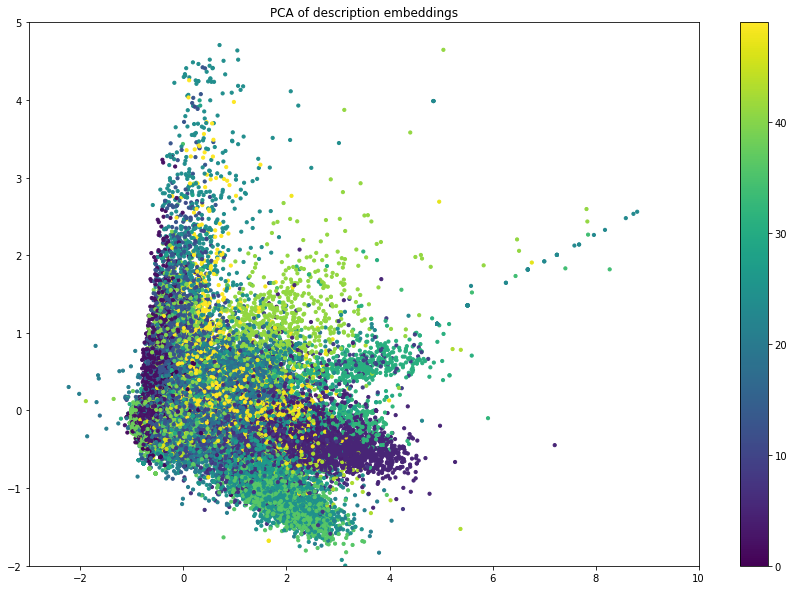

In [14]:
%matplotlib inline

fig = plt.figure(figsize=(15,10))
scatter = plt.scatter(reduced[:,0], reduced[:,1], c=clusters_assgn, s=10)
plt.colorbar(scatter)
# plt.axis([-1,2.5,-4,1.5])
plt.axis([-3,10,-2,5])
# plt.title("PCA of cotrained description embeddings")
plt.title("PCA of description embeddings")
# plt.title("t-SNE of description embeddings (10k)")
# fig.savefig('/usr0/home/mamille2/tumblr/results/pca_cotrain.png', dpi=100)
fig.savefig('/usr0/home/mamille2/tumblr/results/pca_desc_recent5.png', dpi=100)
# fig.savefig('/usr0/home/mamille2/tumblr/results/tsne_cotrain.png', dpi=100)
# fig.savefig('/usr0/home/mamille2/tumblr/results/tsne_desc.png', dpi=100)
fig.show()

In [25]:
clu_ctr = Counter(clusters_assgn)
clu_ctr

Counter({0: 24,
         1: 96,
         2: 59,
         3: 1,
         4: 139,
         5: 29,
         6: 194,
         7: 3,
         8: 48,
         9: 66,
         10: 1,
         11: 126,
         12: 1,
         13: 162,
         14: 133,
         15: 17,
         16: 7,
         17: 39,
         18: 3,
         19: 82,
         20: 24,
         21: 1,
         22: 128,
         23: 7,
         24: 216,
         25: 1,
         26: 47,
         27: 2,
         28: 6,
         29: 20,
         30: 1,
         31: 62,
         32: 737,
         33: 5,
         34: 1,
         35: 1,
         36: 230,
         37: 7,
         38: 1,
         39: 182,
         40: 1,
         41: 465,
         42: 12,
         43: 4,
         44: 105,
         45: 454,
         46: 32,
         47: 1,
         48: 5,
         49: 4})

# Run GMM clustering on blog descriptions

In [2]:
# Load data
desc_emb_path = '/usr0/home/mamille2/tumblr/data/desc_embeddings_avg.npy'
desc_emb = np.load(desc_emb_path)
desc_emb.shape

(4617128, 300)

In [21]:
X = desc_emb[:500000,:]
clf = GaussianMixture(n_components=50, verbose=2, warm_start=True)
clf.fit(X)

Initialization 0


KeyboardInterrupt: 

In [6]:
outpath = '/usr0/home/mamille2/tumblr/data/gmm_20_desc.pkl'

with open(outpath, 'wb') as f:
    pickle.dump(clf, f)

## Try to continue training a model

In [3]:
# Load model
# path = '/usr0/home/mamille2/tumblr/data/gmm_20_desc.pkl'
path = '/usr0/home/mamille2/tumblr/data/gmm_50_desc.pkl'

with open(path, 'rb') as f:
    clf = pickle.load(f)

In [30]:
X = desc_emb[:500000,:]
clf.fit(X)

Initialization 0


KeyboardInterrupt: 

# Examine trained GMM

In [2]:
# Load data
# desc_emb_path = '/usr0/home/mamille2/tumblr/data/desc_embeddings_avg.npy'
# desc_emb_path = '/usr0/home/mamille2/tumblr/data/desc_recent5_embeddings_avg.npy'
desc_emb_path = '/usr0/home/mamille2/tumblr/data/desc_recent5_embeddings_sum.npy'
desc_emb = np.load(desc_emb_path)
desc_emb.shape

(3992, 300)

In [3]:
# Load model
# path = '/usr0/home/mamille2/tumblr/data/gmm_20_desc.pkl'
# path = '/usr0/home/mamille2/tumblr/data/gmm_50_desc.pkl'
# path = '/usr0/home/mamille2/tumblr/data/gmm_cotrain_50_desc.pkl'
path = '/usr0/home/mamille2/tumblr/data/gmm_cotrain_50_desc_sum.pkl'

with open(path, 'rb') as f:
    clf = pickle.load(f)

In [17]:
# Load descriptions
# path = '/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl'
path = '/usr0/home/mamille2/tumblr/data/desc_recent5.pkl'
desc_df = pd.read_pickle(path)

# descs = desc_df['parsed_blog_description'].tolist()
desc_toks = desc_df['tokenized_blog_description'].tolist()

In [5]:
# clf.bic(desc_emb[:500000,:]) # -615M for 20 comps, -652M for 50 comps
clf.bic(desc_emb)

14416957.655118914

In [6]:
clf.lower_bound_

554.49986363703295

In [7]:
# Get highest weights
wted_comps = np.argsort(clf.weights_)[::-1]
wted_comps

array([ 6, 40,  4,  0, 27, 28, 12, 39, 13,  7, 26,  8, 23, 14, 20, 49, 17,
       46, 30,  9, 31, 25, 32,  3, 42, 19, 36, 45, 48, 44, 33, 38,  2,  5,
       15, 21,  1, 16, 18, 24, 10, 22, 37, 34, 29, 11, 43, 41, 47, 35])

## Examine datapoints with highest probabilities assigned for each cluster; examine cluster assignments

In [8]:
# probs = clf.predict_proba(desc_emb[:500000,:])
probs = clf.predict_proba(desc_emb)
probs.shape

(3992, 50)

In [9]:
top_probs = np.argsort(probs, axis=0)[::-1]
top_probs.shape

(3992, 50)

In [22]:
def top_descs(probs, descs, k, order, vocab_file=None):
    """ Prints top k descriptions for each component"""
    
    top_probs = np.argsort(probs, axis=0)[::-1]
    
    if vocab_file: # dict [n_words]: [vocab]
        with open(vocab_file, 'rb') as f:
            vocab = pickle.load(f)
    
    for i in order:
        print("Component {}".format(i))
        col = top_probs[:,i]
#     for i, c in enumerate(top_probs.T):
        
        for el in col[:k]: 
            if vocab_file:
                print('\t' + ' '.join(d if d in vocab[100000] else '<unk>' for d in descs[el])) # for tokenized
            else:
                print('\t' + ' '.join(d if d in vocab[100000] else '<unk>' for d in descs[el])) # for tokenized
#             print('\t' + descs[el])
            
        print()

In [23]:
# Top descriptions from halfday co-training, sum
top_descs(probs, desc_toks, 20, wted_comps, '/usr0/home/mamille2/tumblr/data/halfday_top5_vocab100000.pkl')

Component 6
	<unk> <unk> <unk>
	.
	background casting data
	« peace of mind comes from within »
	<unk> on yahoo
	euronews on yahoo
	<unk> on yahoo
	<unk> on yahoo
	<unk>
	<unk>
	<unk> 이야기 그리고 <unk>
	soccer <unk> m ;)
	duel me
	exhausted but trying
	<unk>
	news from <unk>
	( ͡° ͜ʖ ͡° )
	<unk> on yahoo
	sloths in space
	<unk>

Component 40
	sebastian <unk> . sniper .
	i 'm dying squirtle
	ask for new <unk>
	polyvore fashion page now
	none of this is real
	my name is alex and
	stress is my <unk> .
	<unk> <unk> <unk> <unk>
	anal in the am
	<unk> dearest one .
	here for louis tomlinson
	<unk> <unk> <unk> <unk> az <unk>
	abc news videos on yahoo
	bottom of the <unk> sound
	pensamientos <unk> sobre <unk>
	<unk> are all mad <unk>
	hoe for seventeen and exo
	my name is andrew
	moved to <unk> ! ! !
	we write plays and books !

Component 4
	god someone just bring gabriel back .
	bisexual male that loves tumblr and kindness
	lion state of <unk> <unk> cali di <unk>
	not all of me will die    ( they

In [10]:
# Top descriptions from just descriptions (50 components)
top_descs(probs, descs, 20, wted_comps)

Component 39
	15 yo disabled/sped High School student. Graduating in 2019. I thought making a studyblr would be a good idea for some reason. icon by desferal
	they/them
	This is for the lovers of Dougie Poynter's Tattoo! If you love Dougie Poynter (who doesn't) then you will love this Tumblr! Follow us on Twitter @DougiesTattoo. Thanks!
	Sam | July 23 | Leo | "Light can always be found if one just remembers to turn on the light"
	Sydney. Single. God  < 3 Drama free. Worry free. Staying classy. NOT trashy. (:
	My name is Emma. Im 17 and live in London :D
	| Sadie a begginer cosplayer | Dating the love of my life lesspale-more-pale | next con & cosplay ~ Supercon (48days) Edward Elric (Fullmetal Alchmist)
	I mainly post pictures of oli and his old girlfriend Sarah and some memes so enjoy
	Inspired by the "Humans of New York" page. Get to know more about your VCU community.
	I have a slight obsession with pineapples/thorki/ destiel/ stony / stucky / johnlock /spidypool/ Star Wars/ avenger

	Hockey player
	Dyamond Mahone  < 3
	you die if  you  try
	Eye See All and  Lose It
	All the fan girl stuff than people around me won’t understand 👽
	cute  < 3
	Celebrating .. Love .. Sex ! Women !

Component 33
	Random thoughts!
	i post things i like
	Random Random Random
	Take it.
	I like stapling shit.
	Now Im Nothing
	I am live for me not you!
	my life in pictures
	Hi there.
	Welcome to Super Thierry's World
	Thoughts on Life
	cool stuff
	The life I live
	It's the little things.
	i'm sad
	by: Lynnda Mordoch
	it's good.
	Just random stuff
	Take a time out
	Random.

Component 38
	bored af
	Just stuff I like ok?
	this is all trash
	i'm the weird girl with a blog!..
	Pizza is life
	You make me lol
	im gay
	Just a fangirl.
	little and new to tumblr
	Me. . . I guess?
	Don't mess with me
	I don't know I'm just sad.
	i just wanna draw
	Just Be You LOL
	Love is......
	Just a person who likes to draw :)
	Not an ordinary human
	I love to draw and being funny
	what a piece of fuck this shit is

In [28]:
# Top descriptions from halfday co-training, averages
top_descs(probs, descs, 20, wted_comps)

Component 19
	*SFW* Lilith Age 19 Little age 4-7 Bi-Sexual. I like cute things that make me happy. I am taken by a loving daddy. 
	They always told me to chase my dreams What if I dream of being dead?
	hi im gamzee and i have an applesauce addiction. please use they/them or he/him pronouns when referring to me :o)
	i'm olivia and harry styles owns this ass
	follow me @janecrocker413
	Hi i'm Ember and use they/them.
	I take imagine and ship requests!
	Cause my life is dope and I do dope shit - Kanye West
	love this show so much~bellarke
	20✨-🇲🇽-CA🌞Sehun is my ult but Lay won't leave me alone
	▪ currently reading What We Left Behind by Robin Talley ▪ talk to me! ▫ ask box open ▪ icon by pinklilies ▪
	▪hi I'm Hikari and I'm a multifandom geek▪anime and gay ships are my life▪I do headcanons for my fandoms and the occasional cringey jokes▪on wattpad@Grell_Smutcliff(*^o^*)▪
	hey i'm kevin and i hope u have a Good Time here at shithead central
	I wish I was as cool as the void
	Love yourself 

## Find closest words in embedding space to cluster means
Doesn't really mean anything, as are averaging embeddings across all words in a post and 'dmitry' is closest to each cluster mean

In [24]:
path = '/usr0/home/mamille2/tumblr/data/desc_ftvecs100000.pkl'

with open(path, 'rb') as f:
    wd_embs = pickle.load(f)
    
len(wd_embs[100000])

100000

In [26]:
closests = []
dist = euclidean

for m in tqdm(clf.means_):
    closest_dist = np.infty
    closest_wd = None
    
    for wd, emb in wd_embs[100000].items():
        if dist(m,emb) < closest_dist:
            closest_wd = wd
            
    closests.append(closest_wd)
    
closests

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

['dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry',
 'dmitry']

# Sample blog descriptions for analysis

In [3]:
# Load data
# data = pd.read_csv('/usr0/home/mamille2/tumblr/data/en_nan_blog_descriptions.csv')
data = pd.read_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv')
print(len(data))
data.columns

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6,7,8,9,10,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4617128


Index(['tumblog_id', 'activity_time_epoch', 'tumblr_blog_name',
       'tumblr_blog_title', 'tumblr_blog_description', 'tumblr_blog_url',
       'tumblr_blog_theme', 'is_group_blog', 'is_primary', 'is_private',
       'created_time_epoch', 'updated_time_epoch', 'timezone', 'language',
       'blog_classifier', 'generated_date', 'parsed_blog_description'],
      dtype='object')

In [5]:
pd.set_option('display.max_colwidth', 999)

In [9]:
s = data.sample(n=10)
s.loc[:, ['tumblog_id', 'tumblr_blog_name', 'tumblr_blog_title', 'tumblr_blog_url', 'timezone', 'tumblr_blog_description', 'parsed_blog_description']]

,tumblog_id,tumblr_blog_name,tumblr_blog_title,tumblr_blog_url,timezone,tumblr_blog_description,parsed_blog_description
3625145,331658591.0,diggybangs,NaN,https://diggybangs.tumblr.com/,Australia/Canberra,Diggy Bangs.,Diggy Bangs.
518383,246641476.0,lollycipe-blog,❤Marïa Manuela❤,https://lollycipe-blog.tumblr.com/,US/Eastern,13 anos 💋 l Portugal 💋 l Aveiro 💋 l Andreia ❤ l Xana ❤ l Helena '26 ❤ l Rafa ❤ l Tomás ❤ l Gabi ❤ l Telmo B.❤ l Edu ❤ l Ele ❤,13 anos 💋 l Portugal 💋 l Aveiro 💋 l Andreia ❤ l Xana ❤ l Helena '26 ❤ l Rafa ❤ l Tomás ❤ l Gabi ❤ l Telmo B.❤ l Edu ❤ l Ele ❤
3414511,107954785.0,missionsandjesuslikethings-blog,MissionandJesuslikethings,http://missionsandjesuslikethings-blog.tumblr.com/,US/Mountain,My journey to the great unknown of missions.,My journey to the great unknown of missions.
2919762,351700714.0,jm-dalla,∞,https://jm-dalla.tumblr.com/,US/Eastern,17 / greece / k-pop / movies,17 / greece / k-pop / movies
2488729,246323799.0,creseselia,ˏˋ claude zhao ˎˊ,https://creseselia.tumblr.com/,US/Eastern,"<p>""To see you smile is to feel the sun.""</p><p>➳ other account: @imagineclaude</p><p>Wattpad: @piplupin</p>","""To see you smile is to feel the sun.""➳ other account: @imagineclaudeWattpad: @piplupin"
1545902,14225153.0,pechetty-blog,Apoptosis,http://pechetty-blog.tumblr.com/,US/Eastern,Fresh Anonymity,Fresh Anonymity
1506853,300915956.0,janiraaclaveer,Angus Young💥,https://janiraaclaveer.tumblr.com/,US/Eastern,AC/DC😍,AC/DC😍
679111,310173390.0,chelo-tblr-by-paby,tu y yo así piensalo,https://chelo-tblr-by-paby.tumblr.com/,US/Eastern,gay love,gay love
1454846,199337636.0,3l3phantworld,Embrace every moment,https://3l3phantworld.tumblr.com/,US/Eastern,Laugh. Breathe. Believe.,Laugh. Breathe. Believe.
578457,362108892.0,yclibra17,Libra A,https://yclibra17.tumblr.com/,US/Eastern,<p>from Taiwan</p>,from Taiwan


## Blog descriptions from blogs that have text posts in halfday

In [11]:
text_posts = pd.read_pickle('/usr0/home/mamille2/tumblr/data/halfday_text.pkl')
print(len(text_posts))
text_posts.columns

3078642


Index(['post_id', 'activity_time_epoch', 'tumblog_id', 'post_title',
       'post_short_url', 'post_type', 'post_caption', 'post_format',
       'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'is_submission', 'source_title', 'source_url', 'post_classifier',
       'blog_classifier', 'accepts_answers', 'reblogged_from_post_id',
       'reblogged_from_metadata', 'root_post_id', 'body', 'mentions',
       'post_tags', 'restrictedtags_200freq'],
      dtype='object')

In [17]:
# Blogs that also have text descriptions
tumblogs_allposts = text_posts['tumblog_id'].unique()
len(tumblogs_allposts)

726081

In [ ]:
count_series = text_posts.groupby(['tumblog_id']).size()

In [23]:
tumblogs_2posts = count_series[count_series >= 2].index

In [25]:
tumblogs_5posts = count_series[count_series >= 5].index

In [27]:
tumblogs_10posts = count_series[count_series >= 10].index

In [13]:
data_text = data[data['tumblog_id'].isin(tumblogs_allposts)]
len(data_text)

20792

In [31]:
data_text2 = data[data['tumblog_id'].isin(tumblogs_2posts)]
len(data_text2)

11547

In [26]:
data_text = data[data['tumblog_id'].isin(tumblogs_5posts)]
len(data_text)

4432

In [29]:
data_text10 = data[data['tumblog_id'].isin(tumblogs_10posts)]
len(data_text10)

1797

In [30]:
# Sample from those who have at least 10 text posts in halfday

s = data_text10.sample(n=10)
s.loc[:, ['tumblog_id', 'tumblr_blog_name', 'tumblr_blog_title', 'tumblr_blog_url', 'timezone', 'tumblr_blog_description', 'parsed_blog_description']]

,tumblog_id,tumblr_blog_name,tumblr_blog_title,tumblr_blog_url,timezone,tumblr_blog_description,parsed_blog_description
1568767,149821420.0,thenerdologist,"Few Even Think To Ask ""The Question""",https://thenerdologist.tumblr.com/,US/Eastern,<p>Use the pain of loss...</p><p>instagram: john_daniel_pena</p>,Use the pain of loss...instagram: john_daniel_pena
4324756,243213825.0,audiblewince,Leo,https://audiblewince.tumblr.com/,US/Eastern,"<p>im @audiblewince on most sites</p><p>awful artist/cosplayer</p><p>he/him</p><p>i love to scream abt my sporadic interests</p><p><a href=""https://audiblewince.tumblr.com/post/165012768777/about"">about</a> <a href=""https://ko-fi.com/A3073DHJ"">Buy Me a Coffee</a></p>",im @audiblewince on most sitesawful artist/cosplayerhe/himi love to scream abt my sporadic interestsabout Buy Me a Coffee
309030,322787978.0,redpalladiin,I’d die for Mike Wheeler,http://redpalladiin.tumblr.com/,US/Pacific,<p>meme man </p>,meme man
635577,234918721.0,ghostpai,NaN,http://ghostpai.tumblr.com/,US/Eastern,hey,hey
123339,206644517.0,mattsmithdavidtennant,Whatever I like,https://mattsmithdavidtennant.tumblr.com/,US/Eastern,personal account,personal account
3313680,222004619.0,slitherioking-daniel,･:*:✼✿ Terrific,http://slitherioking-daniel.tumblr.com/,US/Eastern,<p>Martina</p><p>16 </p>,Martina16
2534749,331408628.0,professorcactus,:'),https://professorcactus.tumblr.com/,US/Eastern,<p>My name is meel. I'm a succulent enthusiast.</p>,My name is meel. I'm a succulent enthusiast.
1339682,226535409.0,wooden-cat,Not That Nice,https://wooden-cat.tumblr.com/,US/Eastern,shit,shit
3830198,246553170.0,makenziedoughnut,Nor Nor,https://makenziedoughnut.tumblr.com/,US/Eastern,I AM THE FLAMINGO QUEEN,I AM THE FLAMINGO QUEEN
3233745,270185245.0,mostlikelylauren,NaN,https://mostlikelylauren.tumblr.com/,US/Eastern,"<a href=""https://mostlikelylauren.tumblr.com/tagged/me"">Lauren</a> | 21 | NC</p><p>Morgan | Soccer</p><p>IG: laurenellis04</p>",Lauren | 21 | NCMorgan | SoccerIG: laurenellis04


In [32]:
# Sample from those who have at least 2 text posts in halfday

s = data_text2.sample(n=10)
s.loc[:, ['tumblog_id', 'tumblr_blog_name', 'tumblr_blog_title', 'tumblr_blog_url', 'timezone', 'tumblr_blog_description', 'parsed_blog_description']]

,tumblog_id,tumblr_blog_name,tumblr_blog_title,tumblr_blog_url,timezone,tumblr_blog_description,parsed_blog_description
1253256,292040519.0,royilz,Kush&wizdom,https://royilz.tumblr.com/,US/Eastern,<p>Kush and wizdomm</p>,Kush and wizdomm
2988811,245928069.0,foreignbrat,☽,http://foreignbrat.tumblr.com/,US/Pacific,twenty // california,twenty // california
2180905,256295412.0,mihdun,I will face god and walk backwards into hell,https://mihdun.tumblr.com/,US/Eastern,hello I am Midon. science.,hello I am Midon. science.
1682082,258016116.0,25island,Cowboy Kid - King of the Worms,https://25island.tumblr.com/,US/Eastern,❤💀Leader of the sad boys club 💀❤,❤💀Leader of the sad boys club 💀❤
2449032,142460101.0,julyrod11,If.,http://julyrod11.tumblr.com/,US/Eastern,<p>Hooyah Never Quit..</p><p>CO</p>,Hooyah Never Quit..CO
2526403,314518533.0,itsthekiks,It's Kiki,https://itsthekiks.tumblr.com/,US/Eastern,Mostly about anime and novels and kitties. A little about art. Over 30. Poly Bi Cis Lady.,Mostly about anime and novels and kitties. A little about art. Over 30. Poly Bi Cis Lady.
887235,311103498.0,m00ngal,ukulele players dont interact,http://m00ngal.tumblr.com/,US/Eastern,º hi im adrian/riley and i exist sometimes • trans enby • 14 • aries sun/cancer moon/virgo rising • gay as hell • ENTP • beginner witch º ~terfs/swerfs/ddlg/nsfw blogs stay away~,º hi im adrian/riley and i exist sometimes • trans enby • 14 • aries sun/cancer moon/virgo rising • gay as hell • ENTP • beginner witch º ~terfs/swerfs/ddlg/nsfw blogs stay away~
176349,307488570.0,agayboysblog69,The sea witch,https://agayboysblog69.tumblr.com/,US/Eastern,just a gay | male witch | learning and growing in the craft,just a gay | male witch | learning and growing in the craft
1637973,270359067.0,tanubear101,Hola.,https://tanubear101.tumblr.com/,US/Eastern,<p>CW :75 kgs. GW: 60 UGW: 55.</p><p>💘</p>,CW :75 kgs. GW: 60 UGW: 55.💘
855948,48975674.0,yougotafraninmee,Laughing With Anger,http://yougotafraninmee.tumblr.com/,US/Pacific,<p>Francella. 24. Los Angeles Area. IG&amp;Twitter: Yougotafraninme</p>,Francella. 24. Los Angeles Area. IG&Twitter: Yougotafraninme


# LSA on blog descriptions

## Get blog descriptions

In [2]:
# Load data
# data = pd.read_csv('/usr0/home/mamille2/tumblr/data/en_nan_blog_descriptions.csv')
data = pd.read_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv')
print(len(data))
data.columns

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6,7,8,9,10,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4617128


Index(['tumblog_id', 'activity_time_epoch', 'tumblr_blog_name',
       'tumblr_blog_title', 'tumblr_blog_description', 'tumblr_blog_url',
       'tumblr_blog_theme', 'is_group_blog', 'is_primary', 'is_private',
       'created_time_epoch', 'updated_time_epoch', 'timezone', 'language',
       'blog_classifier', 'generated_date', 'parsed_blog_description'],
      dtype='object')

In [4]:
blog_descs = data['parsed_blog_description'].values
blog_descs.shape

(4617128,)

## Get tfidf matrix

In [5]:
tfidf = TfidfVectorizer(max_features=100000)
tfidf_mat = tfidf.fit_transform(blog_descs)
tfidf_mat.shape

(4617128, 100000)

## Do SVD

In [6]:
svd = TruncatedSVD(n_components=300)
svd_mat = svd.fit_transform(tfidf_mat)
svd_mat.shape

(4617128, 300)

In [7]:
svd.explained_variance_ratio_.sum() 
# 17% with 100 components over full vocab 
# 22% with 100 components over top 100k words
# 34% with 300 components over top 100k words

0.33799431595227575

In [8]:
# Words x components matrix
svd.components_.shape

(300, 100000)

In [9]:
# word features
feats = tfidf.get_feature_names()
len(feats)

100000

## Get ranked word features by component

In [10]:
top = np.argsort(svd.components_)[:100]
top.shape

(100, 100000)

In [11]:
top_sub = top[:, :100]
top_sub.shape

(100, 100)

In [12]:
feats2names = np.vectorize(lambda x: feats[x])
top_feats = feats2names(top_sub)
top_feats

array([['zlatanstrophywife', 'gerardwaay', 'qwertyuiop', ...,
        '単身パックの見積もりハテナのマーク', '車査定ウルフの高額買取', 'シアリス通販'],
       ['you', 'the', 'me', ..., 'because', 'something', 'little'],
       ['you', 'page', 'me', ..., 'from', 'someone', 'look'],
       ..., 
       ['14', 'old', 'years', ..., 'doing', 'made', 'loves'],
       ['free', 'up', 'idk', ..., 'shut', 'world', 'download'],
       ['happy', 'anything', 'never', ..., 'fm', 'down', 'date']], 
      dtype='<U26')

In [14]:
for i, factor in enumerate(top_feats):
    print('Factor {}'.format(i))
    pprint(factor)
    print()

Factor 0
array(['zlatanstrophywife', 'gerardwaay', 'qwertyuiop',
       '将全球游戏玩家转换成我们用户的娱乐经营理念', '提供多种多样休闲娱乐产品给全球超过3000万会员', '走向世界',
       '牢牢坚持面向亚欧', 'ooie', 'onlineko', 'bbbbb', 'hhhhhhhhh', 'jufjfhg',
       'clintbxrtn', 'yuer', 'giribouy', 'sajlor', 'gentlemangos', 'eoq',
       'edit_tumblelog', 'theme_id', '636545', 'ohmygodstiel',
       'tiniagoldstein', 'lesbianmonarch', 'tralalalala', '21rj',
       'unfuckwithable', 'mionamisugi', '32929', 'hellloooooo', 'hfndb',
       '취향대로', 'ooiid', '大家过来学', 'hiiiiiiiiiiiiiiii', 'philsshirts',
       '19さい', 'fuckthepopulation', '并深受广大玩家喜爱', '随时为广大玩家提供最为即时的线上游戏娱乐项目',
       '致力于打造一个方便快捷的线上游戏娱乐平台', 'iloveyounamjoo', 'rainyjelena',
       'myhotcomments', 'leesoohyukswife', 'npi', 'discription1',
       'just4fun', 'lemonmenace', '这里是联系方式', 'qq123456', '你看我的联系方式是什么',
       '薬通販', 'ディプリックスシアリス20', 'ディプリックス', 'シアリス20', 'klasno', 'シアリス',
       'セット割引', 'ディプロ', 'undescription', 'tdh', 'bet官方中文网址', 'バイあグラ',
       '13913374256货到付币', '872050

In [13]:
np.save('/usr0/home/mamille2/tumblr/data/lsa_descriptions_topwords.npy', top_feats)

## Get ranked documents by component

In [15]:
top_docs_idx = np.argsort(svd_mat.T) # Select 10 highest components
top_docs_idx.shape

(300, 4617128)

In [16]:
top_docs_idx = top_docs_idx[:100]
top_docs_idx.shape

(100, 4617128)

In [17]:
top_sub = top_docs_idx[:, :100]
top_sub.shape

(100, 100)

In [18]:
idx2docs = np.vectorize(lambda x: blog_descs[x])
top_docs = idx2docs(top_sub)
top_docs

array([['asdflkasjflk', 'zlatanstrophywife', 'zlatanstrophywife', ...,
        'Ooie *³*', '@onlineko', '@onlineko'],
       ['love you to The 🌜and🔙', 'Love me and you',
        'Forevor. Love. You. And. Me.', ..., 'Me and You.', 'Me and you',
        'You and Me'],
       ['& you love me', 'me love you', 'You+me=Love', ..., 'You & Me',
        'YOU&ME<3', 'You&Me'],
       ..., 
       ['14 years old', '14 years old.', '14 years old 👍', ...,
        'Im 14 Years Old.', '14 year old♥', 'a 14 year old'],
       ['Get Free', 'GET FREE', 'get free', ..., 'free', 'free! 弱虫 排球',
        'Free.'],
       ['I never post anything ¯\\_(ツ)_/¯', 'I never post anything :-)',
        'I will never post anything.', ..., 'Happy =D', 'happy', 'b happy']], 
      dtype='<U1541')

In [19]:
for i, factor in enumerate(top_docs):
    print('Factor {}'.format(i))
    pprint(factor)
    print()

Factor 0
array(['asdflkasjflk', 'zlatanstrophywife', 'zlatanstrophywife',
       'zlatanstrophywife', 'zlatanstrophywife', 'zlatanstrophywife',
       'zlatanstrophywife', 'zlatanstrophywife',
       'zlatanstrophywife biiiiitch', 'zlatanstrophywife',
       'zlatanstrophywife', 'zlatanstrophywife', 'zlatanstrophywife',
       'zlatanstrophywife', 'zlatanstrophywife', 'zlatanstrophywife',
       'zlatanstrophywife', 'zlatanstrophywife', 'zlatanstrophywife',
       'zlatanstrophywife', 'zlatanstrophywife', 'zlatanstrophywife',
       'zlatanstrophywife', 'zlatanstrophywife', 'zlatanstrophywife',
       'zlatanstrophywife', 'zlatanstrophywife',
       'zlatanstrophywife biiiiitch', 'zlatanstrophywife', '圖檔儲存blog',
       'moepic17\u3000moepic18\u3000萌え連\u3000ネタ連\u3000詳細希望\u3000壁連\u3000和連\u3000詳細希望裏\u3000萌え裏\u3000詳細漫画裏\u3000壁裏',
       'asfasfasfsf', '@gerardwaay', '@gerardwaay ', '@gerardwaay',
       '@gerardwaay', '@gerardwaay ', '@gerardwaay', '@gerardwaay',
       '@gerardwaay', '@ge

In [20]:
np.save('/usr0/home/mamille2/tumblr/data/lsa_descriptions_topdocs.npy', top_docs)